# <b><span style='color:#DC143C'>|</span> EXPLANABLE AI AND MODEL INTERPRETABILITY</b>

Sources : 
* [Explain your models with LIME]("https://medium.com/dataman-in-ai/explain-your-model-with-lime-5a1a5867b423")
* [Explain your models with SHAP]("https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d")
* [Permutation Importance]("https://www.kaggle.com/dansbecker/permutation-importance")

Why do we need explanability in the project?

Using Explanable AI, we can get answers to questions like : 
* Why our model is predicting the values for a particular test sample?
* What are the variables positively correlated with the target?
* What are negatively correlated with the target?
* What variables have the highest importance in making predictions for the whole dataset/for a single example?

# <b><span style='color:#DC143C'>|</span> PERMUTATION IMPORTANCE WITH ELI5 LIBRARY</b>

Permutation Importance is a method of understanding which features are of highest importance to our model.It ranks the features according to the weights in descending order of their importance.

The algorithm that Permutation Importance uses to get the insights is very interesting and novel.It's easy to understand and it overcomes the shortcomings of other feature importance methods.

1. First we train our model,here the xgboost model in our case on the train set.

2. Then we use the model as it is to get the predictions on our validation set.Then the rmse is calculated.

3. Further,the column whose feature importance has to be calculated is randomly shuffled.So,now our validation set is shuffled on 1 column.Then Step 2 is repeated on the shuffled validation set.The new rmse is compared to the old rmse and if there is an increase in the error,the feature importance is high,i.e. the shuffled feature was crucial in making predictions.It may also be possible that rmse decreases on shuffling or there is no change,then the shuffled feature is of nil importance to the model.The decrease in rmse after shuffling can be attributed to chance /luck or lower size of dataset that means higher probability of luck.

4. The validation set is then unshuffled to it's original state and the same steps are repeated for other features (one at a time) and then we obtain the feature importances.


In [4]:
import numpy as np
import pandas as pd
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
# import shap
from sklearn.preprocessing import StandardScaler


In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("Number of train samples are",train.shape)
print("Number of test samples are",test.shape)
categorical_features = ['State_Factor', 'building_class', 'facility_type']
numerical_features=train.select_dtypes('number').columns

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)


In [8]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


Text(0.5, 1.0, 'Missing values in training Data')

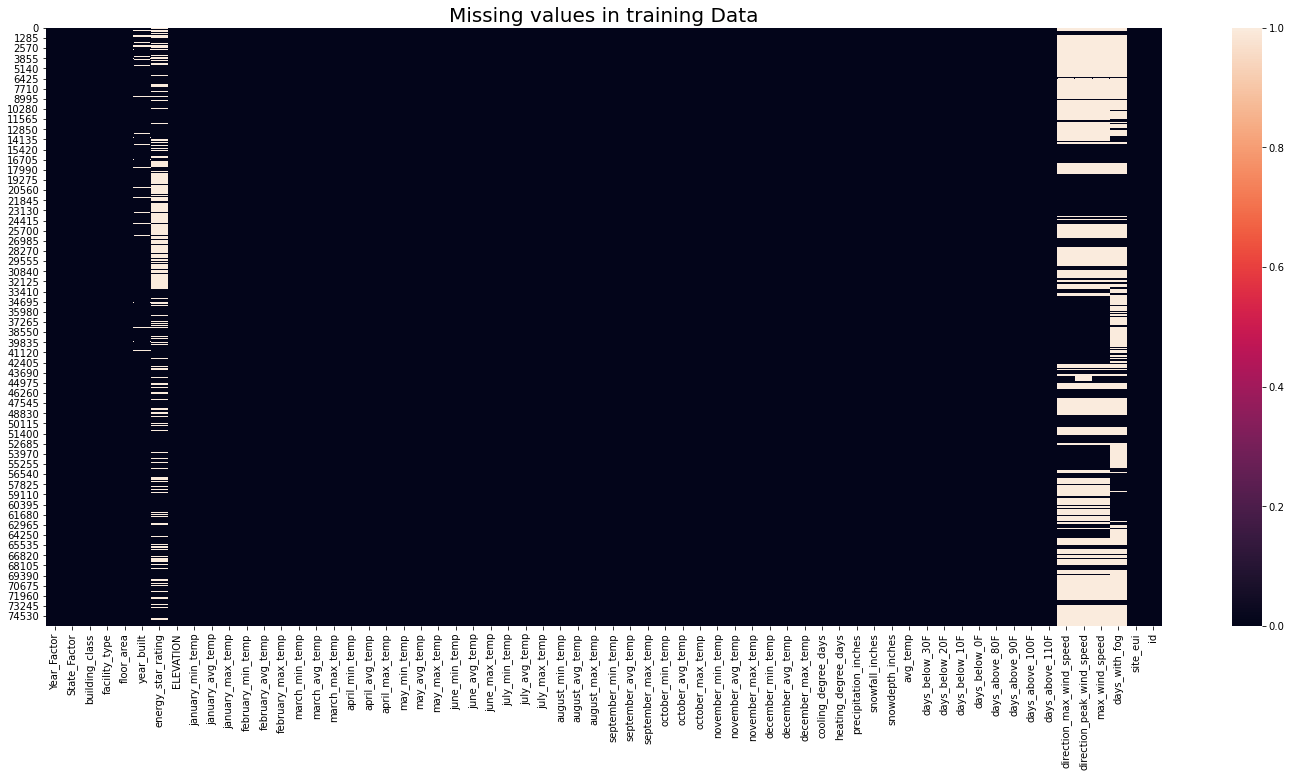

In [9]:
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, xticklabels=train.columns)
plt.title("Missing values in training Data", size=20)

In [10]:
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap="Pastel1")

train['year_built'] =train['year_built'].replace(np.nan, 2022)
test['year_built'] =test['year_built'].replace(np.nan, 2022)
null_col=['energy_star_rating','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog']
imputer = SimpleImputer()
imputer.fit(train[null_col])
data_transformed = imputer.transform(train[null_col])
train[null_col] = pd.DataFrame(data_transformed)
test_data_transformed = imputer.transform(test[null_col])
test[null_col] = pd.DataFrame(test_data_transformed)

Text(0.5, 1.0, 'Missing values in training Data')

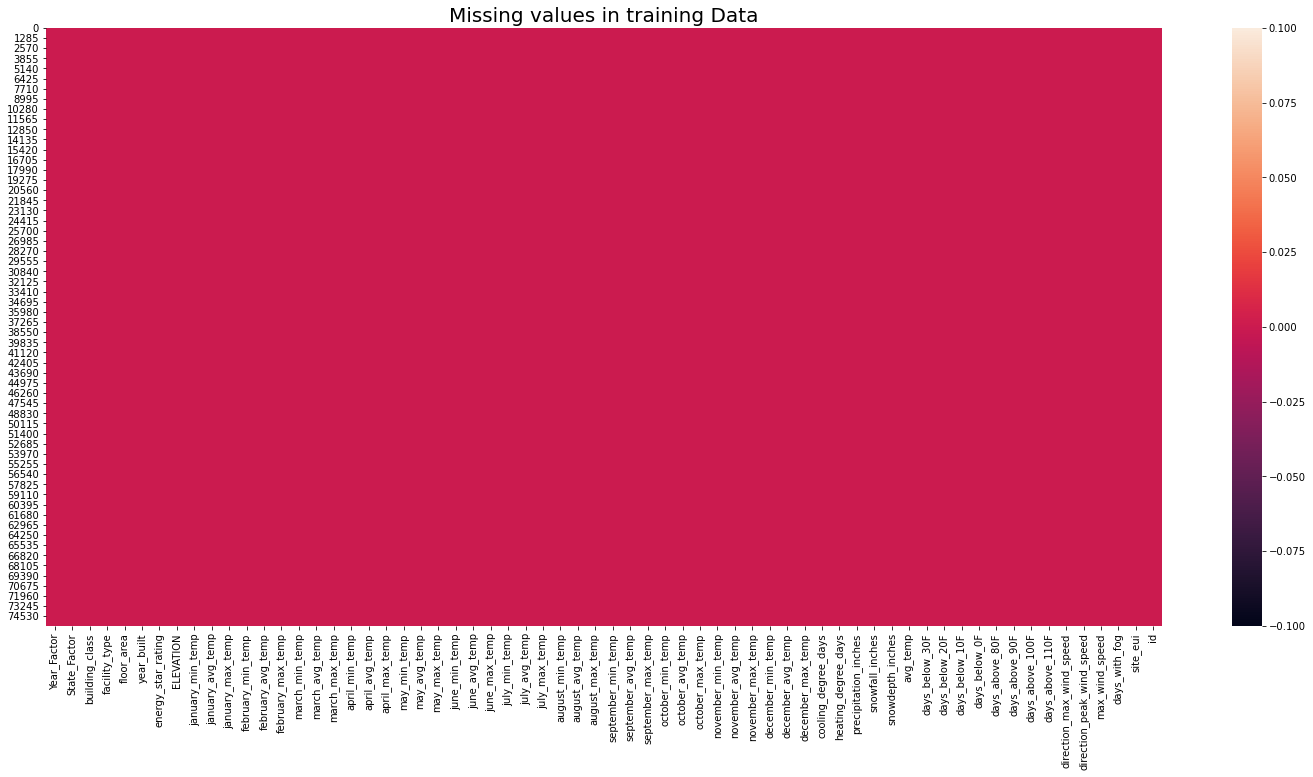

In [11]:
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, xticklabels=train.columns)
plt.title("Missing values in training Data", size=20)

In [12]:
le = LabelEncoder()
for col in categorical_features:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])


In [13]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,0,0,13,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.000000,1.0,109.142051,248.682615,0
1,1,0,0,55,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,62.779974,1.0,12.000000,26.500150,1
2,1,0,0,48,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,62.779974,1.0,12.000000,24.693619,2
3,1,0,0,6,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,62.779974,1.0,12.000000,48.406926,3
4,1,0,0,56,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.000000,1.0,109.142051,3.899395,4


In [14]:
import copy
y = train["site_eui"]
train = train.drop(["site_eui","id"],axis =1)
test = test.drop(["id"],axis =1)
trainnames = copy.deepcopy(train)
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
